In [14]:
import os
import sys
from random import randint, seed

sys.path.append('../')

import numpy as np
import networkx as nx
from networkx.algorithms.community import louvain_communities, modularity

import leidenalg as la
from scripts.clustering import leiden
from scripts.filtration import FiltrationClustering

import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score

from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

In [2]:
def compute_metrics(G, true_labels, pred_labels):
    # Convert communities to label lists (node order must match)
    nodes = sorted(G.nodes())
    true_labels = [true_labels[node] for node in nodes]
    pred_labels = [pred_labels[node] for node in nodes]

    nmi = adjusted_mutual_info_score(true_labels, pred_labels)
    print(f"AMI: {nmi:.5f} | interval: [0, 1]")

    ari = adjusted_rand_score(true_labels, pred_labels)
    print(f"ARI: {ari:.5f} | interval: [-0.5, 1]")


# Emails

In [3]:
# Load graph (edges)
G = nx.read_edgelist("./data/email-Eu-core.txt", nodetype=int)
G.remove_edges_from(nx.selfloop_edges(G))

# Load ground-truth communities (node: community_id)
ground_truth = {}
with open("./data/email-Eu-core-department-labels.txt") as f:
    for line in f:
        node, label = map(int, line.strip().split())
        ground_truth[node] = label

# Convert ground truth to partition format (list of sets)
ground_truth_partition = {}
for node, comm in ground_truth.items():
    ground_truth_partition.setdefault(comm, set()).add(node)
ground_truth_partition = list(ground_truth_partition.values())

pos = nx.spring_layout(G)

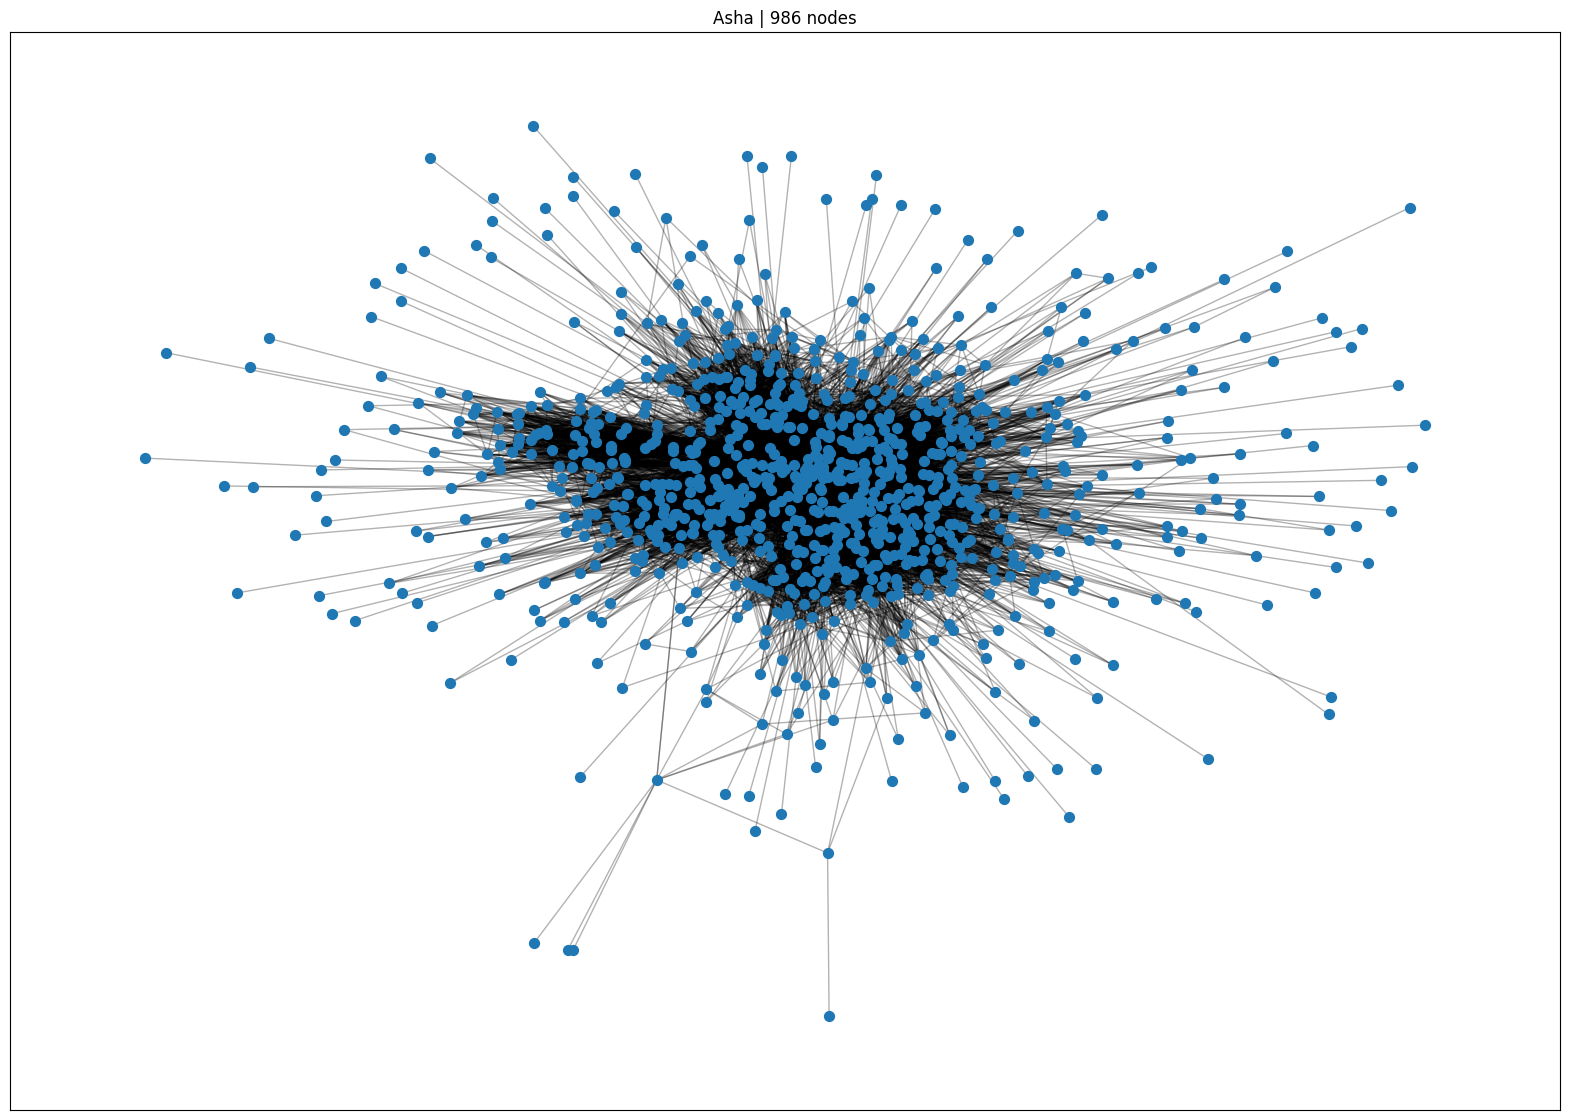

In [4]:
def plot_graph(G):
    plt.figure(figsize=(20, 14))
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f'Asha | {len(G.nodes)} nodes')


main_component = sorted(nx.connected_components(G), key=len, reverse=True)[0]
plot_graph(G.subgraph(main_component))

# Clusterings

In [5]:
def plot_communities(communities, pos, algo_name=''):
    plt.figure(figsize=(20, 14))

    nx.draw_networkx_edges(G, pos, alpha=0.3)

    for j, cluster in enumerate(communities):
        color = '#%06X' % randint(0, 0xFFFFFF)
        for v in cluster:
            point = pos[v]
            plt.scatter(point[0], point[1], c=color)

    plt.title(f'{algo_name} | {len(communities)} clusters')

## Louvain

Modularity: 0.41302
AMI: 0.55793 | interval: [0, 1]
ARI: 0.35045 | interval: [-0.5, 1]


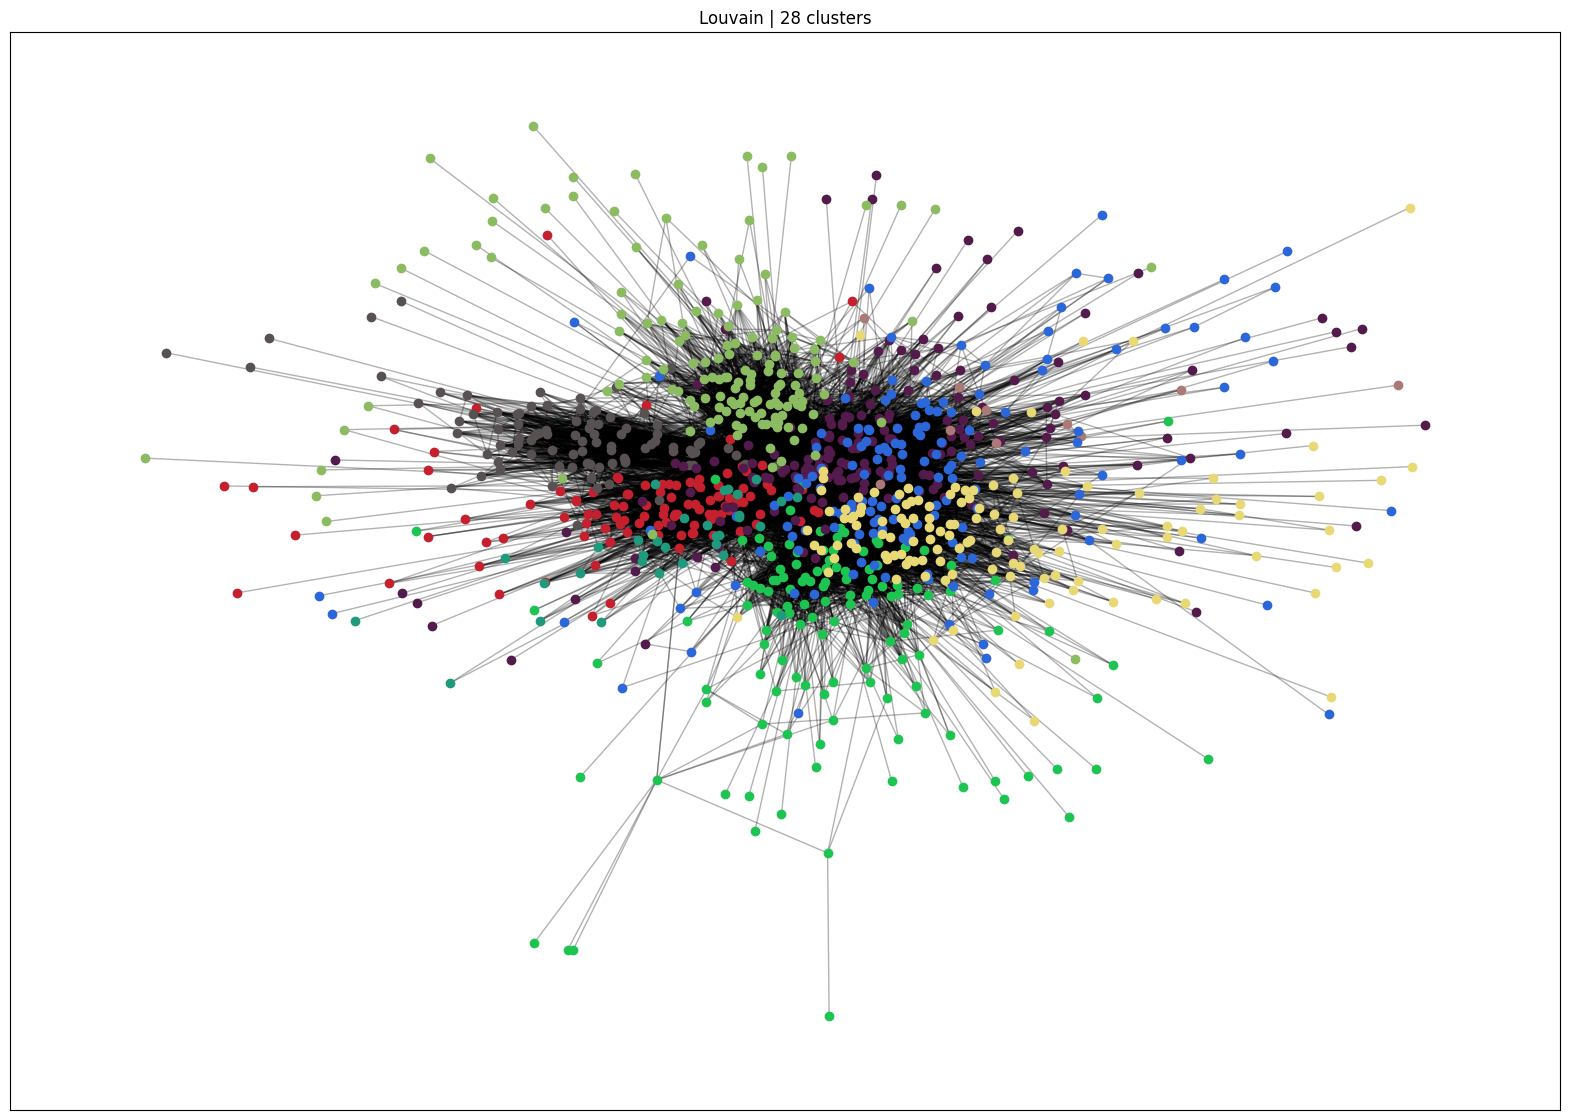

In [6]:
seed(0xAB0BA)

# Run Louvain with default parameters
louvain_partition = louvain_communities(G, seed=42)
print(f'Modularity: {modularity(G, louvain_partition):.5f}')

# Convert Louvain output to node: community_id format
louvain_labels = {}
for i, comm in enumerate(louvain_partition):
    for node in comm:
        louvain_labels[node] = i

compute_metrics(G, ground_truth, louvain_labels)

plot_communities([[v for v in c if v in main_component] for c in louvain_partition], pos, algo_name='Louvain')

## Leiden

Modularity: 0.41611
AMI: 0.53132 | interval: [0, 1]
ARI: 0.28940 | interval: [-0.5, 1]


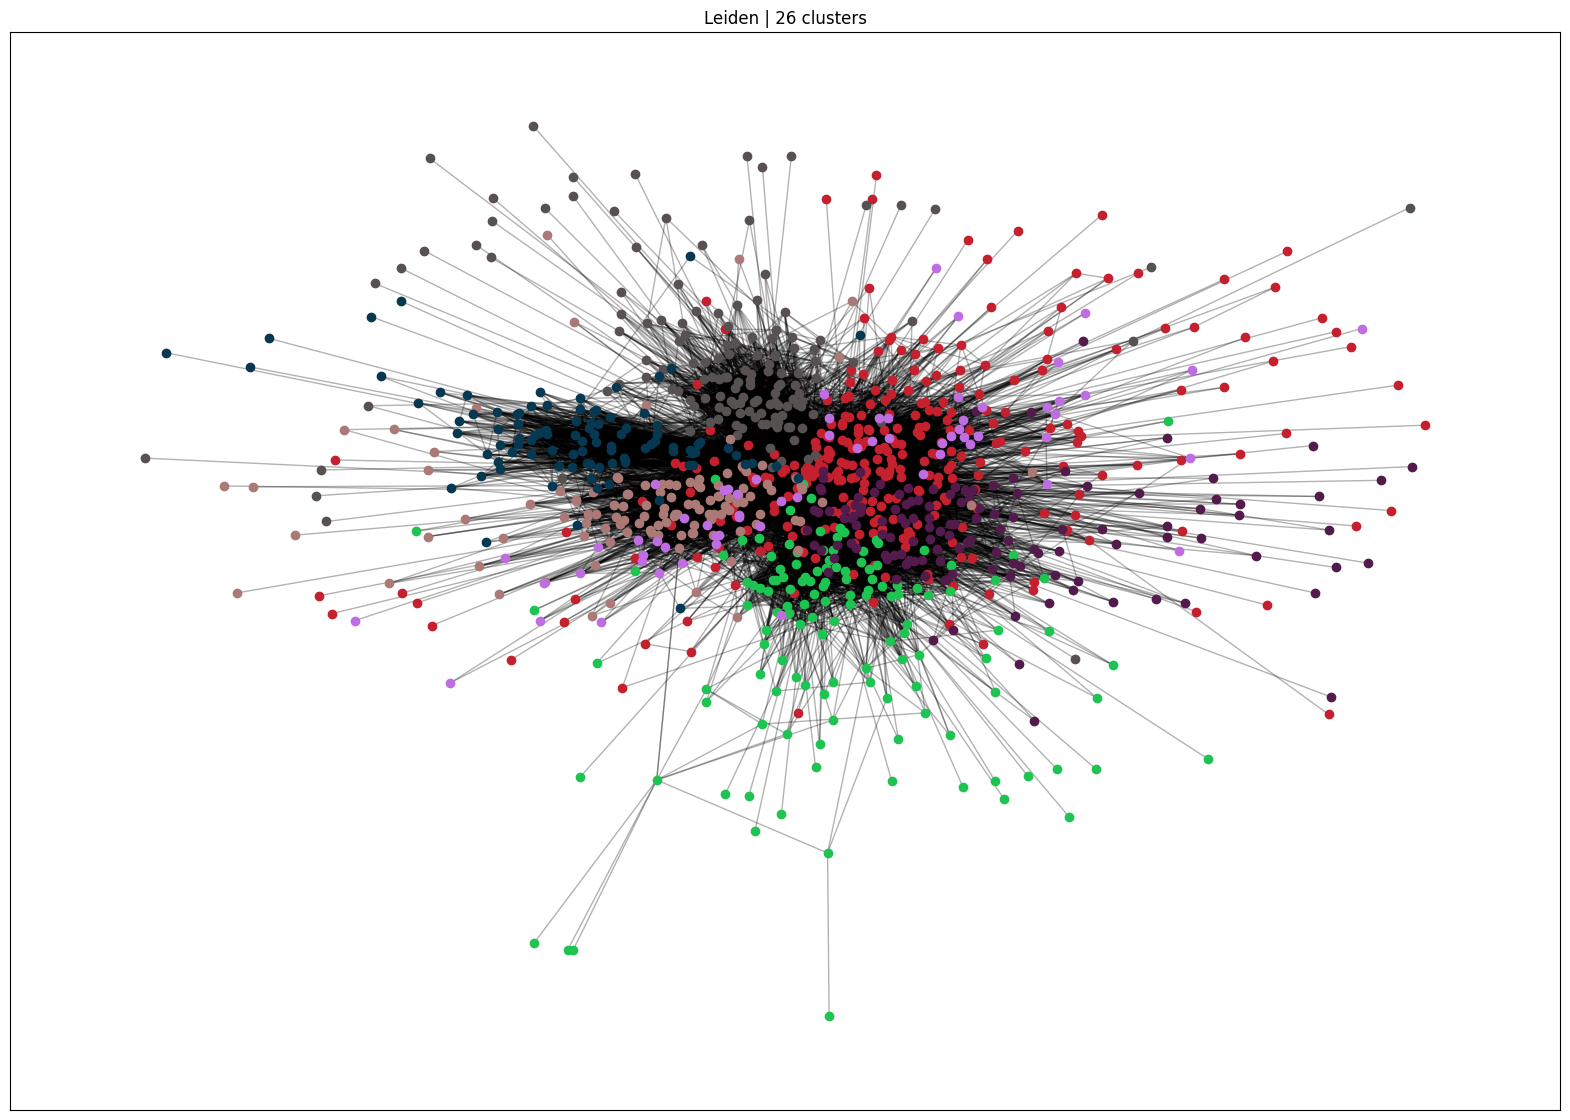

In [7]:
seed(0xAB0BA)

communities = leiden(G, partition_type=la.ModularityVertexPartition, seed=0xAB0BA)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
louvain_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        louvain_labels[node] = i

compute_metrics(G, ground_truth, louvain_labels)

plot_communities([[v for v in c if v in main_component] for c in communities], pos, algo_name='Leiden')

## Filtration
Because graphs here may not have weights, we will use graph curvature instead.


In [8]:
print("\n===== Compute the Ollivier-Ricci curvature of the given graph G =====")
# compute the Ollivier-Ricci curvature of the given graph G
orc = OllivierRicci(G, alpha=0.5, verbose="INFO")
orc.compute_ricci_curvature()
print("Karate Club Graph: The Ollivier-Ricci curvature of edge (0,1) is %f" % orc.G[0][1]["ricciCurvature"])

print("\n===== Compute the Forman-Ricci curvature of the given graph G =====")
frc = FormanRicci(G)
frc.compute_ricci_curvature()
print("Karate Club Graph: The Forman-Ricci curvature of edge (0,1) is %f" % frc.G[0][1]["formanCurvature"])

# -----------------------------------
print("\n=====  Compute Ricci flow metric - Optimal Transportation Distance =====")
G = nx.karate_club_graph()
orc_OTD = OllivierRicci(G, alpha=0.5, method="OTD", verbose="INFO")
orc_OTD.compute_ricci_flow(iterations=10)
print("\n=====  Compute Ricci community - by Ricci flow =====")
clustering = orc_OTD.ricci_community()


===== Compute the Ollivier-Ricci curvature of the given graph G =====
Karate Club Graph: The Ollivier-Ricci curvature of edge (0,1) is 0.090952

===== Compute the Forman-Ricci curvature of the given graph G =====
Karate Club Graph: The Forman-Ricci curvature of edge (0,1) is -46.000000

=====  Compute Ricci flow metric - Optimal Transportation Distance =====

=====  Compute Ricci community - by Ricci flow =====


In [20]:
# Compute OllivierRicci curvature
orc = OllivierRicci(G, alpha=0.5, verbose="INFO")
G_orc = orc.compute_ricci_curvature()

# Shift curvature values, so that they start with zero
min_curv = min([d['ricciCurvature'] for _,_,d in G_orc.edges(data=True)])

for a, b in G_orc.edges:
    G_orc[a][b]['ricciCurvature'] -= min_curv

Performing Filtration Clustering


100%|██████████| 1000/1000 [00:00<00:00, 3395.81it/s]


Finding best clustering


100%|██████████| 1000/1000 [00:00<00:00, 13344.01it/s]


Best threshold 0.6698 with score: 0.39661474077639214
Modularity: 0.37853
AMI: 0.18974 | interval: [0, 1]
ARI: 0.12127 | interval: [-0.5, 1]


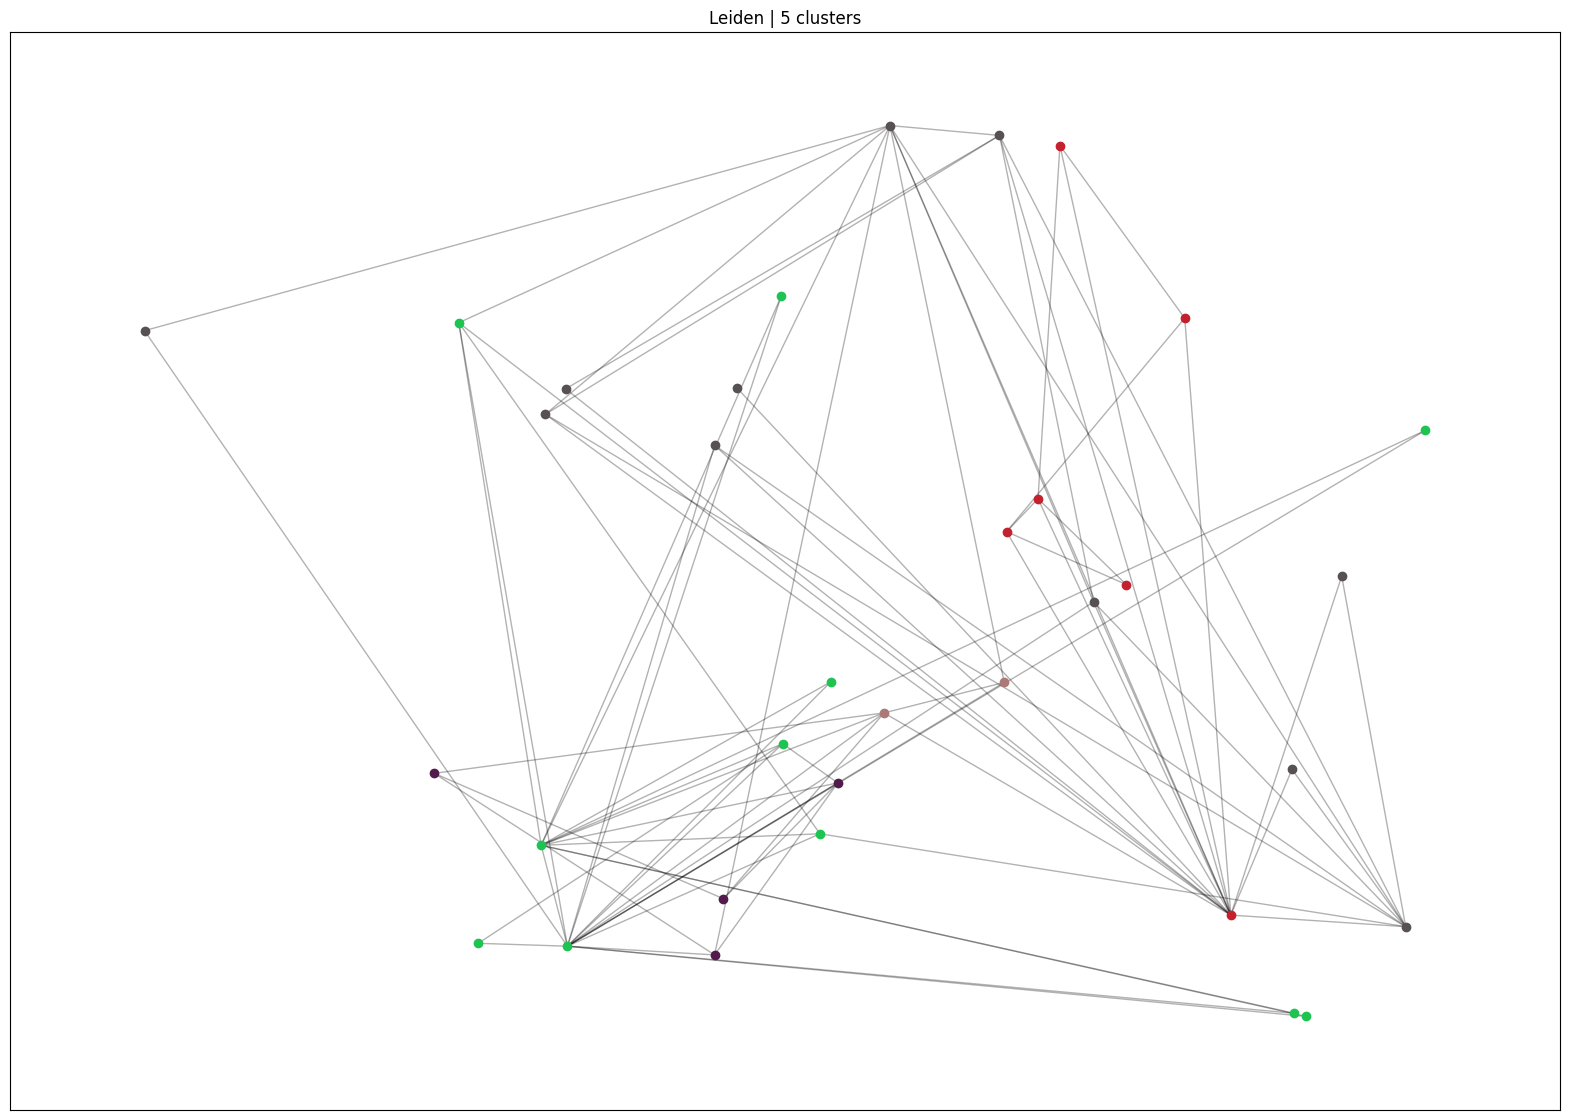

In [30]:
np.random.seed(0xAB0BA)
seed(0xAB0BA)

fc = FiltrationClustering(G_orc, weight='ricciCurvature')
communities = fc.cluster(quantiles=np.linspace(1e-1, 1, 1000), n_jobs=os.cpu_count()-1)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
louvain_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        louvain_labels[node] = i

compute_metrics(G, ground_truth, louvain_labels)

plot_communities([[v for v in c if v in main_component] for c in communities], pos, algo_name='Leiden')